<p style="text-align:left;">
   <a href="../README.md">Ir al menú anterior</a>
   <span style="float:right;">
        <a href="../README.md">Ir a la unidad anterior</a>
   </span>
</p>

-----

# Dos partículas de Lennard-Jones

<div class="alert alert-info" role="alert">
<strong>Info:</strong> Si crees que este notebook necesita algún cambio no dudes en <a href="../../../../UIBCDF-Academia/Como_contribuir/Como_contribuir.md" class="alert-link">contribuir a su desarrollo</a>.
</div>

<br>

- [Simulación del sistema](#Simulación-del-sistema)
- [Script de Python](#Script-de-Python)
- [El sistema en OpenMolecularSystems](#El-sistema-en-OpenMolecularSystems)

## Simulación del sistema

Las siguientes celdas recojen las instrucciones necesarias para simular la dinámica de Langevin de dos partículas de Lennard-Jones en vacio con OpenMM. La trayectoria (tiempos, posiciones, velocidades, energías cinéticas y potenciales) son guardadas como numpy arrays.

In [1]:
import numpy as np
from tqdm import tqdm
import simtk.openmm as mm
import simtk.openmm.app as app
import simtk.unit as unit

In [2]:
# Definición del sistema.

## Primer átomo: Argón
mass_1 = 39.948 * unit.amu
sigma_1 = 3.404 * unit.angstroms
epsilon_1 = 0.238 * unit.kilocalories_per_mole
charge_1 = 0.0 * unit.elementary_charge

## Segundo átomo: Xenón
mass_2 = 131.293 * unit.amu
sigma_2 = 3.961 * unit.angstroms
epsilon_2 = 0.459 * unit.kilocalories_per_mole
charge_2 = 0.0 * unit.elementary_charge


# Creación del sistema.

system = mm.System()

non_bonded_force = mm.NonbondedForce()
non_bonded_force.setNonbondedMethod(mm.NonbondedForce.NoCutoff)

# Átomo 1
system.addParticle(mass_1)
non_bonded_force.addParticle(charge_1, sigma_1, epsilon_1)

# Átomo 2
system.addParticle(mass_2)
non_bonded_force.addParticle(charge_2, sigma_2, epsilon_2)

# Caja periódica

system.setDefaultPeriodicBoxVectors([2.0, 0.0, 0.0]*unit.nanometers, [0.0, 2.0, 0.0]*unit.nanometers, [0.0, 0.0, 2.0]*unit.nanometers)

_ = system.addForce(non_bonded_force)

In [3]:
# Definición del estado termodinámico y el integrador.

step_size = 2*unit.femtoseconds
temperature = 300*unit.kelvin
friction = 1.0/unit.picosecond # Damping para la dinámica de Langevin

integrator = mm.LangevinIntegrator(temperature, friction, step_size)

In [4]:
# Creación de la plataforma.

platform_name = 'CUDA'
platform = mm.Platform.getPlatformByName(platform_name)

In [5]:
# Creación del contexto.

context = mm.Context(system, integrator, platform)

In [6]:
# Condiciones iniciales

initial_positions  = np.zeros([2, 3], np.float32) * unit.angstroms
initial_velocities = np.zeros([2, 3], np.float32) * unit.angstroms/unit.picoseconds

initial_positions[1, 0] = 1.0 * unit.nanometers

context.setPositions(initial_positions)
context.setVelocities(initial_velocities)

In [7]:
# Parámetros de la simulación.

simulation_time = 5.0*unit.nanosecond
saving_time = 1.0*unit.picoseconds

In [8]:
n_steps_per_period = int(saving_time/step_size) # número de pasos del periodo de guardado
n_periods = int(simulation_time/saving_time) # número de periodos guardados

In [9]:
# Creación de arrays reporteros del tiempo, la posición y la velocidad.

times = np.zeros([n_periods], np.float32) * unit.picoseconds
positions = np.zeros([n_periods, 2, 3], np.float32) * unit.angstroms
velocities = np.zeros([n_periods, 2, 3], np.float32) * unit.angstroms/unit.picosecond
potential_energies   = np.zeros([n_periods], np.float32) * unit.kilocalories_per_mole
kinetic_energies     = np.zeros([n_periods], np.float32) * unit.kilocalories_per_mole

In [10]:
# Almacenamiento en reporteros de las condiciones iniciales para tiempo 0

state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
#state = context.getState(getPositions=True, getVelocities=True, getEnergy=True, enforcePeriodicBox=True)
times[0] = state.getTime()
positions[0] = state.getPositions()
velocities[0] = state.getVelocities()
kinetic_energies[0]=state.getKineticEnergy()
potential_energies[0]=state.getPotentialEnergy()

In [11]:
# Ejecuto el bucle sobre el número de periodos que vamos a simular

for ii in tqdm(range(1, n_periods)):
    context.getIntegrator().step(n_steps_per_period)
    state = context.getState(getPositions=True, getVelocities=True, getEnergy=True)
    #state = context.getState(getPositions=True, getVelocities=True, getEnergy=True, enforcePeriodicBox=True)
    times[ii] = state.getTime()
    positions[ii] = state.getPositions()
    velocities[ii] = state.getVelocities()
    kinetic_energies[ii]=state.getKineticEnergy()
    potential_energies[ii]=state.getPotentialEnergy()

100%|██████████| 4999/4999 [00:28<00:00, 172.81it/s]


Por último podemos representar gráficamente la trayectoria con la libreria Matplotlib:

In [12]:
import matplotlib.pyplot as plt

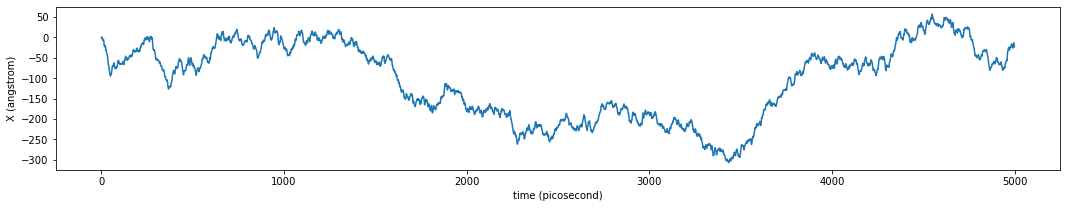

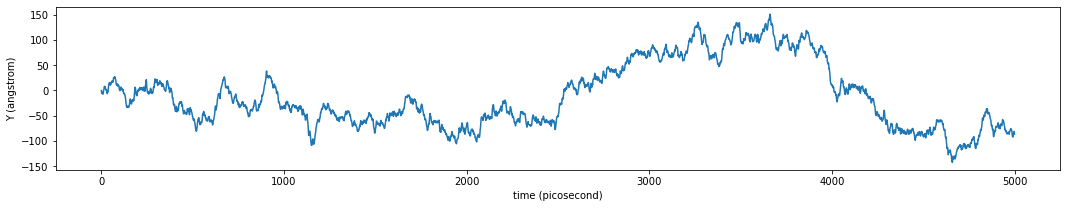

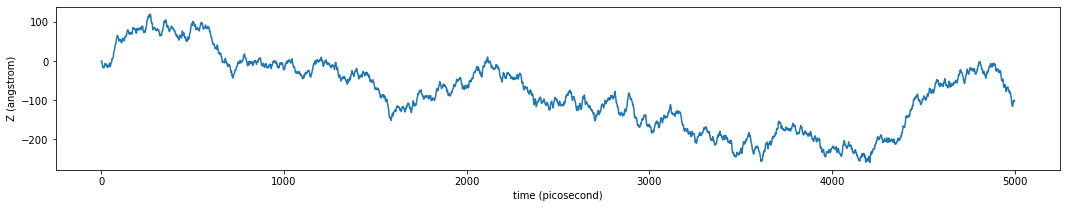

In [13]:
index_particle = 0

plt.rcParams['figure.figsize'] = 18, 3

for ii, axis_label in zip(range(3),['X','Y','Z']):
    plt.plot(times, positions[:, index_particle, ii])
    plt.ylabel('{} ({})'.format(axis_label, positions.unit))
    plt.xlabel('time ({})'.format(times.unit))
    plt.show()

O si preferimos, la trayectoria proyectada por el espacio de dos de las dimensiones, por ejemplo $X$ y $Y$:

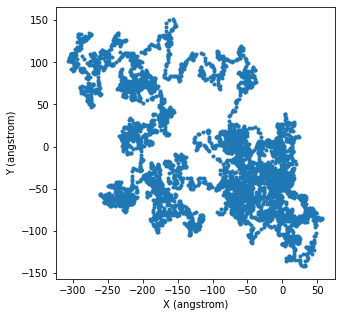

In [14]:
plt.rcParams['figure.figsize'] = 5, 5

plt.plot(positions[:, index_particle,0], positions[:, index_particle,1], '.')
plt.xlabel('X ({})'.format(positions.unit))
plt.ylabel('Y ({})'.format(positions.unit))
plt.show()

Veamos ahora la energía cinética y la energía potencial:

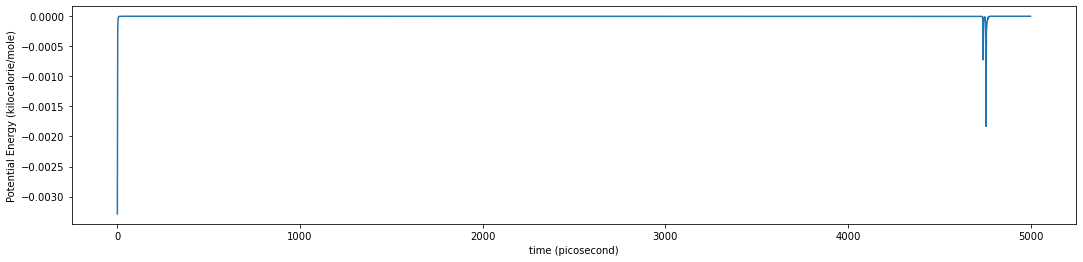

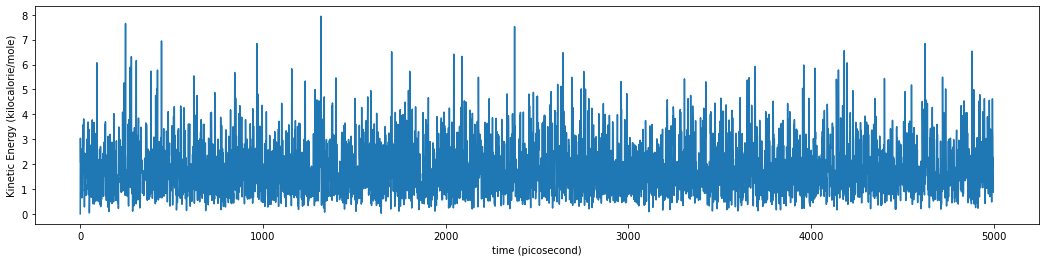

In [15]:
plt.rcParams['figure.figsize'] = 18, 4

plt.plot(times, potential_energies[:])
plt.ylabel('Potential Energy ({})'.format(potential_energies.unit))
plt.xlabel('time ({})'.format(times.unit))
plt.show()

plt.plot(times, kinetic_energies[:])
plt.ylabel('Kinetic Energy ({})'.format(kinetic_energies.unit))
plt.xlabel('time ({})'.format(times.unit))
plt.show()


Cuando Openmm simula un sistema en una caja con condiciones de contorno periódicas, por defecto no trabaja con las coordenadas de los elementos del sistema en la caja. Las partículas se mueven en una trayectoria continua entre las cajas virtuales contiguas interaccionando con las imágenes periódicas del resto de átomos. Si quisíeramos obtener las coordenadas de los elementos del sistema molecular acotadas a la caja de condiciones de contorno periódicas debemos extraer el estado del contexto con la opción `enforcePeriodicBox=True`:

In [16]:
state = context.getState(getPositions=True, getVelocities=True, getEnergy=True, enforcePeriodicBox=True)

Prueba a volver a correr la simulación con la opción `enforcePeriodicBox=True` para comparar el resultado.

## Script de Python

El flujo de ordenes anteriores para llevar a cabo la simulación de dos partículas de Lennard-Jones interaccionando en vacio dentro de una caja periódica en un jupyter notebook, puede ser encontrada también en forma de script en el directorio 'data/openmm_scripts' del repositorio de UIBCDF-Academia en GitHub con el nombre ['dos_particulas_LJ.py'](https://github.com/uibcdf/Academia/tree/main/data/openmm_scripts/dos_particulas_LJ.py). Este puede ser ejecutado en la terminal mediante el siguiente comando:

```bash
python dos_particulas_LJ.py
```

Se genera un archivo llamado 'traj.pkl' con la compresión mediante la librería pickle de los numpy array con unidades para el tiempo, las posiciones, las velocidades, la energía potencial y la energía cinética -en este orden- guardados a intervalos de tiempo definidos en el script.

## El sistema en OpenMolecularSystems

El sistema molecular, en este caso dos partículas de Lennard-Jones, se encuentra disponible en la librería [OpenMolecularSystem](http://www.uibcdf.org/OpenMolecularSystems) desarrollada en la UIBCDF. El sistema puede ser simulado en distintas circunstancias de manera más cómoda haciendo uso de esta libreria.

<div style='text-align: right;'> <a href="../xxx.ipynb">Ir a la siguiente unidad</a> </div>

-------
<p xmlns:cc="http://creativecommons.org/ns#" xmlns:dct="http://purl.org/dc/terms/"><a property="dct:title" rel="cc:attributionURL" href="https://github.com/uibcdf/Academia">UIBCDF-Academia</a> por <a rel="cc:attributionURL dct:creator" property="cc:attributionName" href="https://github.com/uibcdf/Academia/graphs/contributors">UIBCDF Lab, autores y colaboradores</a> es material protegido bajo una licencia <a href="http://creativecommons.org/licenses/by-nc-sa/4.0/deed.es?ref=chooser-v1" target="_blank" rel="license noopener noreferrer" style="display:inline-block;">Attribution-NonCommercial-ShareAlike 4.0 International<img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/cc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/by.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/nc.svg?ref=chooser-v1"><img style="height:22px!important;margin-left:3px;vertical-align:text-bottom;" src="https://mirrors.creativecommons.org/presskit/icons/sa.svg?ref=chooser-v1"></a></p>
